In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import os
from PIL import Image
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
directory_structure = """
ANTBEE_data/
  ants/
    ant_image1.jpg
    ant_image2.jpg
    ...
  bees/
    bee_image1.jpg
    bee_image2.jpg
    ...
"""


In [3]:
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Specify the path to the 'ANTBEE_data' directory
data_dir = '/content/drive/MyDrive/ANTBEE_data'

# Use pathlib.Path to count the number of images in each subdirectory
image_count = len(list(Path(data_dir).glob('*/*.jpg')))
print(image_count)


401


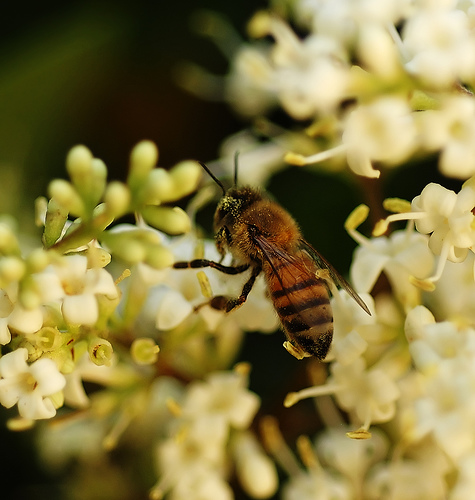

In [5]:
# Create a Path object for 'bees' subdirectory
bees_dir = Path(data_dir) / 'bees'
ants_dir = Path(data_dir) / 'ants'

# List all files in the 'bees' subdirectory with the '*.jpg' extension
bees_files = list(bees_dir.glob('*.jpg'))
ants_files = list(ants_dir.glob('*.jpg'))

# Open the first image from the 'bees' subdirectory using PIL
PIL.Image.open(str(bees_files[0]))




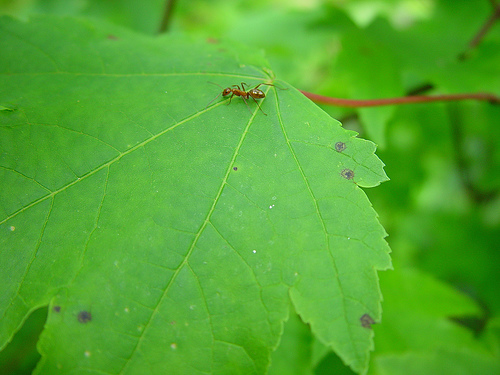

In [6]:
PIL.Image.open(str(ants_files[4]))

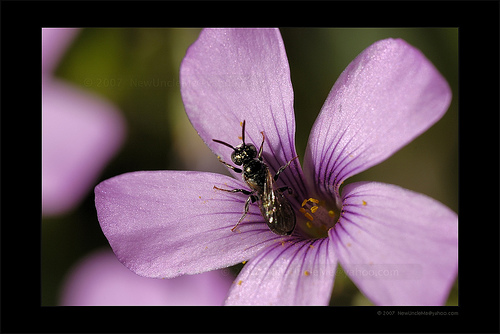

In [7]:
PIL.Image.open(str(bees_files[1]))

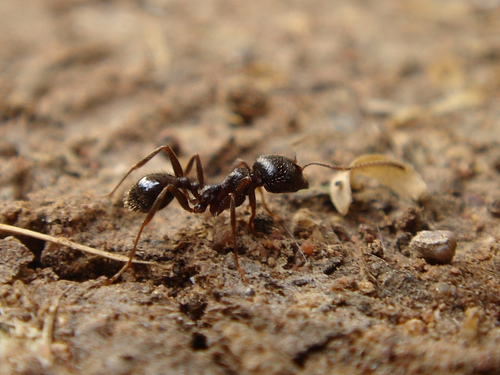

In [8]:
PIL.Image.open(str(ants_files[3]))

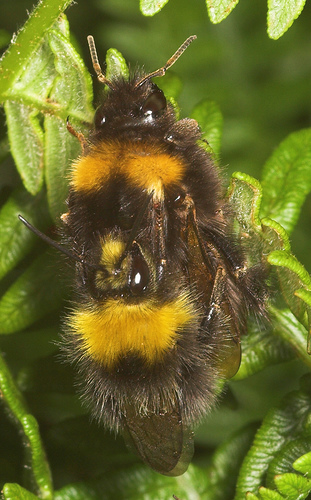

In [9]:
PIL.Image.open(str(bees_files[8]))

In [10]:
batch_size = 32
img_height = 240
img_width = 240

In [11]:
#Use 80% of the images for training and 20% for validation.
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 403 files belonging to 2 classes.
Using 323 files for training.


In [13]:
# Number of batches in the Training dataset. Each batch contains 32 images, except for the last batch.
print(len(train_ds))

11


In [17]:
#number of sub directories under the data_dir
num_files = len(os.listdir(data_dir))
print(num_files)

2


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 403 files belonging to 2 classes.
Using 80 files for validation.


In [18]:
# Number of batches in the validation dataset. Each batch contains 32 images, except for the last batch.
print(len(val_ds))

3


In [20]:
class_names = train_ds.class_names
print(class_names)

['ants', 'bees']


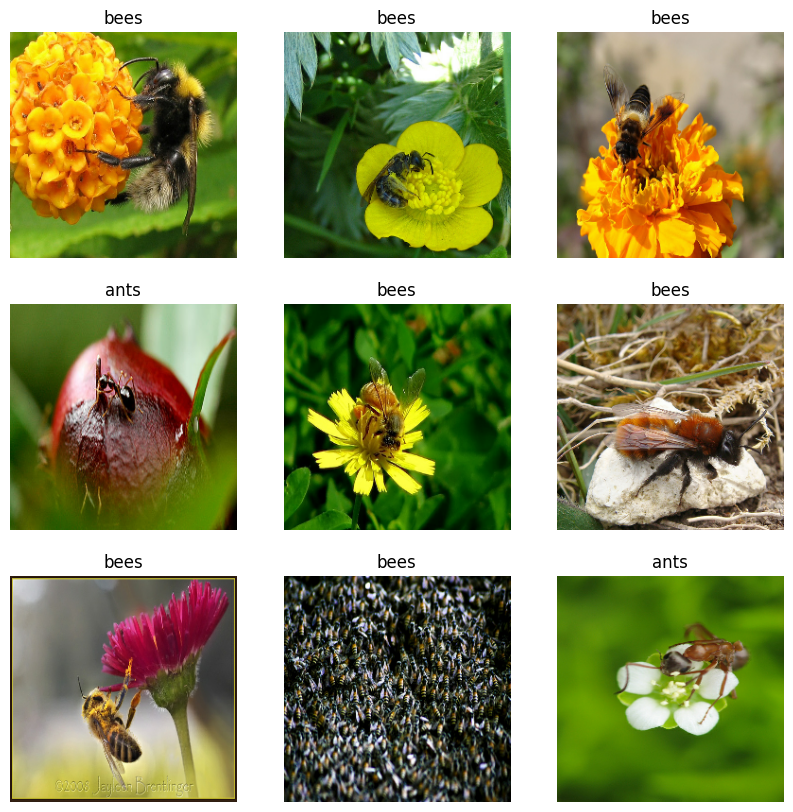

In [21]:
#Visualize the data
#Here are the first nine images from the training dataset

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [34]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 240, 3)
(32,)


In [35]:
#The image_batch is a tensor of the shape (32, 240, 240, 3).
#This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB).
#The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.




In [36]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [37]:
# normalization_layer = layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [38]:
num_classes = len(class_names)
#Standardize the data using rescaling and use the layer inside model definition.
model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


In [39]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
model.build(input_shape=(None, img_height, img_width, 3))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 120, 120, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)       

In [41]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
11/11 [==============================] - 24s 2s/step - loss: 1.0732 - accuracy: 0.5511 - val_loss: 0.7335 - val_accuracy: 0.5250
Epoch 2/15
11/11 [==============================] - 33s 3s/step - loss: 0.6646 - accuracy: 0.6161 - val_loss: 0.6532 - val_accuracy: 0.6250
Epoch 3/15
11/11 [==============================] - 28s 3s/step - loss: 0.6264 - accuracy: 0.6347 - val_loss: 0.6004 - val_accuracy: 0.7125
Epoch 4/15
11/11 [==============================] - 28s 3s/step - loss: 0.5587 - accuracy: 0.7245 - val_loss: 0.5757 - val_accuracy: 0.6875
Epoch 5/15
11/11 [==============================] - 25s 2s/step - loss: 0.4971 - accuracy: 0.7523 - val_loss: 0.6942 - val_accuracy: 0.6125
Epoch 6/15
11/11 [==============================] - 31s 3s/step - loss: 0.4031 - accuracy: 0.8297 - val_loss: 0.5272 - val_accuracy: 0.7125
Epoch 7/15
11/11 [==============================] - 23s 2s/step - loss: 0.3129 - accuracy: 0.8731 - val_loss: 0.6293 - val_accuracy: 0.6375
Epoch 8/15
11/11 [==

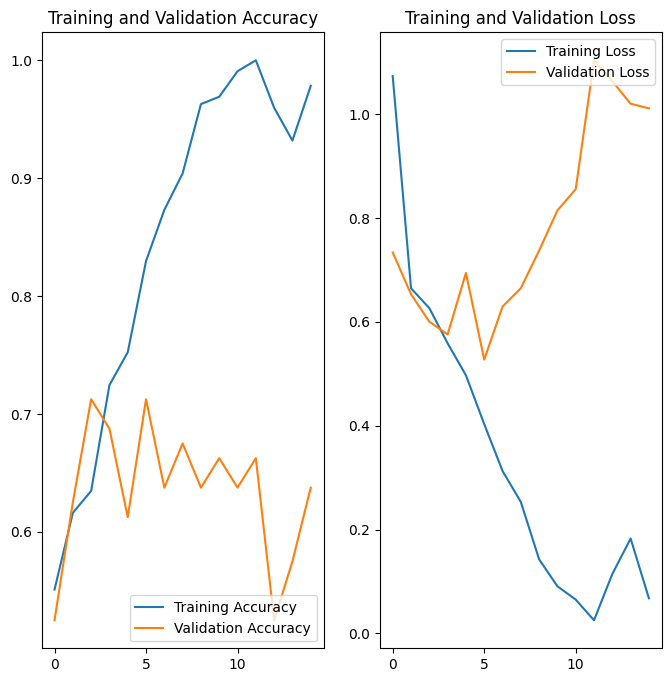

In [43]:
# plots of the loss and accuracy on the training and validation sets
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),

    ]
)

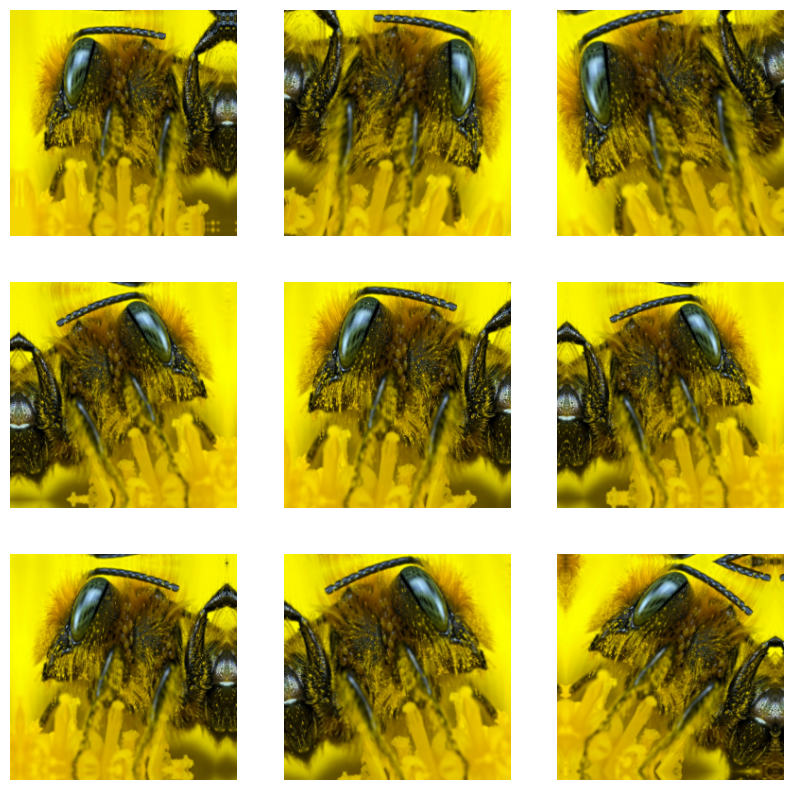

In [45]:
#Visualise the augmentation

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [46]:
#adding data augmentation and dropout layer to the model
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [47]:
#complile and train the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 240, 240, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 240, 240, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 240, 240, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 120, 120, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 60, 60, 32)        0         
 g2D)                                                 

In [49]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
11/11 [==============================] - 29s 2s/step - loss: 1.4746 - accuracy: 0.5108 - val_loss: 0.6589 - val_accuracy: 0.6625
Epoch 2/15
11/11 [==============================] - 25s 2s/step - loss: 0.6676 - accuracy: 0.6068 - val_loss: 0.6281 - val_accuracy: 0.6250
Epoch 3/15
11/11 [==============================] - 25s 2s/step - loss: 0.6189 - accuracy: 0.6347 - val_loss: 0.5409 - val_accuracy: 0.6875
Epoch 4/15
11/11 [==============================] - 26s 2s/step - loss: 0.5824 - accuracy: 0.6842 - val_loss: 0.5855 - val_accuracy: 0.6375
Epoch 5/15
11/11 [==============================] - 26s 2s/step - loss: 0.5841 - accuracy: 0.6997 - val_loss: 0.5945 - val_accuracy: 0.6625
Epoch 6/15
11/11 [==============================] - 23s 2s/step - loss: 0.5718 - accuracy: 0.6656 - val_loss: 0.5015 - val_accuracy: 0.7625
Epoch 7/15
11/11 [==============================] - 27s 2s/step - loss: 0.5384 - accuracy: 0.7059 - val_loss: 0.4974 - val_accuracy: 0.7625
Epoch 8/15
11/11 [==

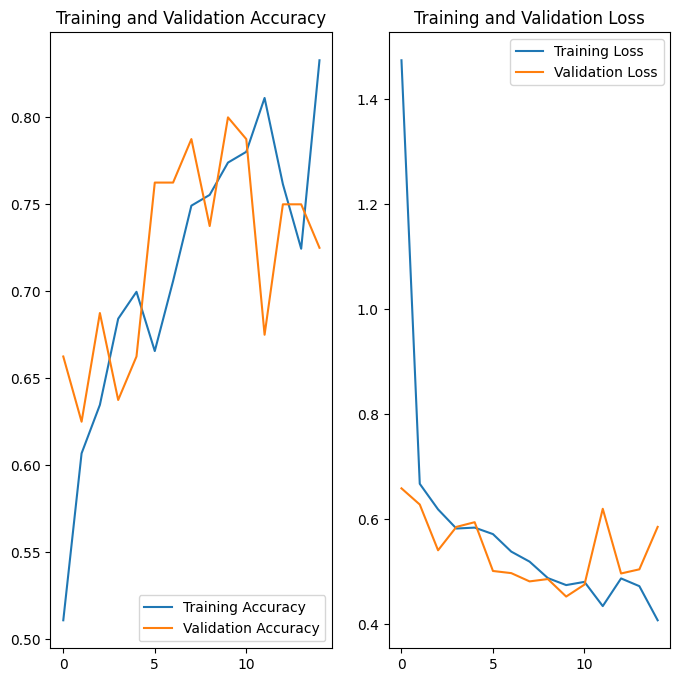

In [50]:
#visualise the training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [75]:
#predicting on new data collected from google
bees_image_url = "https://www.greenqueen.com.hk/wp-content/uploads/2020/05/bee-on-flower-flickr.jpg"

image_path = tf.keras.utils.get_file('bees', origin=bees_image_url)

img = tf.keras.utils.load_img(
    image_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 43ms/step
This image most likely belongs to bees with a 97.40 percent confidence.
